In [19]:
using DataFrames #for data wrangling
using StatsPlots #for plotting
using Turing #for MCMC
using CSV #CSV import
using Random #data generation (if required)
using Distributions
using LogExpFunctions #for logistic function

Import Data

In [20]:
#this is a local document, but i've also saved a slightly cleaned up version in github with the same "valveTestRaw" title
valveData = CSV.read("./Results of New Valve Tests.csv", DataFrame)

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,b,13,0,0,0.00%,0.00%,missing,air
3,c,85,1,1,13.00%,9.70%,175,steam
4,d,108,21,4,4.50%,1.50%,350,air
5,e,1,0,0,0.00%,0.00%,missing,na
6,f,55,9,2,5.50%,2.50%,400,liquid
7,g,41,5,2,6.70%,3.30%,165,steam
8,h,2,0,0,0.00%,0.00%,missing,air
9,z,40,6,1,24.00%,20.00%,165,steam


Collect Number of Trials & Separate into Service Mediums

In [21]:
serviceMediums = ["steam", "air", "liquid", "air/liquid", "na"]
mediumDF = Dict()
vendorDF = Dict()

for medium in serviceMediums
    mediumDF = merge(Dict(medium => filter(:Service => ==(medium), valveData)), mediumDF)
    vendorDF = merge(Dict(medium => mediumDF[medium][:, 1]), vendorDF)
end

vendorDF["steam"]

6-element Vector{String1}:
 "a"
 "c"
 "g"
 "z"
 "k"
 "m"

Set Up Model

In [22]:
@model function valveTesting(Vendors, Population, rejects) # highpops serviceMedium)
    #additional functionality can be added to this, especially when considering that the probability of failing (p-1) is the sum of the probability of failing on a low pop (less dangerous) & a high pop (more dangerous)      
    
    
    #hyper prior
    μ_bar ~ Normal(-2, 2) #best first guess is that most valves are unlikely to fail, possibly with large spread
    σ ~ Exponential(1) #allow possibility of large std dev in data
    
    μ = Vector{Real}(undef, length(Vendors))

    for i in 1:length(Vendors)
        μ[i] ~ Normal(μ_bar, σ) #assume that the logit(probability) is distributed normally for each vendor
    end

    for i in 1:length(Vendors)
        
        #prior
        n = Population[i] #number of trials for binomial function
        p = logistic(μ[i]) #force p (probability of failure) to be 0<p<1
        #distribution of valves failing given fail probability p and n trials
        rejects[i] ~ Binomial(n, p) #binomial distribution used (most appropriate since measuring probability of failure given trial data)
    end
end

valveTesting (generic function with 2 methods)

Implement Model

In [23]:
model = Dict()
posterior = Dict()
posteriorDF = Dict()
for medium in serviceMediums
  model = merge(Dict(medium => valveTesting(mediumDF[medium][:,1], mediumDF[medium][:,2], mediumDF[medium][:,3])), model)
  posterior = merge(Dict(medium => sample(model[medium], NUTS(), 1000)), posterior)
  posteriorDF = merge(Dict(medium => DataFrame(posterior[medium])), posteriorDF)
end

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference C:\Users\flemm\.julia\packages\Turing\oFGEb\src\mcmc\hmc.jl:213
Sampling   0%|█                                         |  ETA: 0:03:08
Sampling   1%|█                                         |  ETA: 0:01:34
Sampling   1%|█                                         |  ETA: 0:01:04
Sampling   2%|█                                         |  ETA: 0:00:47
Sampling   2%|█                                         |  ETA: 0:00:38
Sampling   3%|██                                        |  ETA: 0:00:32
Sampling   3%|██                                        |  ETA: 0:00:27
Sampling   4%|██                                        |  ETA: 0:00:24
Sampling   4%|██                                        |  ETA: 0:00:21
Sampling   5%|██                                        |  ETA: 0:00:19
Sampling   5%|███                                       |  ETA: 0:00:17
Sampling   

Process Data

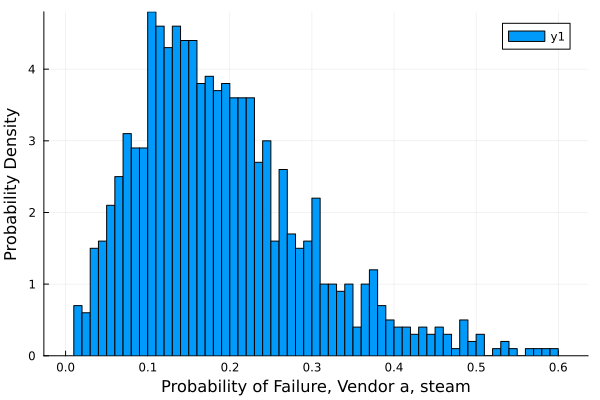

In [24]:
dataProcessed = Dict()
plots = Dict()
for medium in serviceMediums
    vendorProcessed = Dict()
    vendorPlots = Dict()
    for i in 1:length(vendorDF[medium])
        #recover probability of a valve from this vendor & service medium failing an initial pop test
        vendorLog = zeros(nrow(posteriorDF[medium]))
        for j in 1:nrow(posteriorDF[medium])
            vendorLog[j] = logistic(posteriorDF[medium][j, "μ[$i]"])
        end
        vendorProcessed = merge(Dict(vendorDF[medium][i] => vendorLog), vendorProcessed)
        vendorPlot = histogram(vendorProcessed[vendorDF[medium][i]][:], xlab = "Probability of Failure, Vendor " * vendorDF[medium][i] * ", " * medium, ylab = "Probability Density", normalize=:pdf, bins=101)
        vendorPlots = merge(Dict(vendorDF[medium][i] => vendorPlot), vendorPlots)
    end
    dataProcessed = merge(Dict(medium => vendorProcessed), dataProcessed)
    plots = merge(Dict(medium => vendorPlots), plots)
end

#histogram(dataProcessed["steam"][vendorDF["steam"][1]], xlab = "Probability of Failure, Vendor " * vendorDF["steam"][1], ylab = "Probability Density", normalize=:pdf, bins=101)
plot(plots["steam"]["a"])

Predict Valve Failure

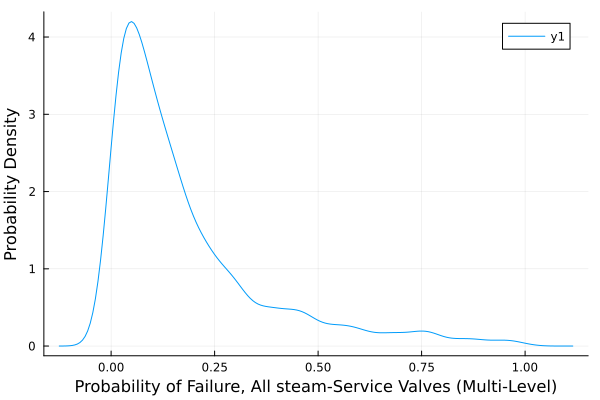

In [25]:
mediumPDF = Dict()
for medium in serviceMediums
  mediumLogodds = rand.(Normal.(posteriorDF[medium].μ_bar[1:1000], posteriorDF[medium].σ[1:1000]))
  mediumPDF = merge(Dict(medium => logistic.(mediumLogodds)), mediumPDF)
end

predict_plot = plot(xlab="Probability of Failure, All " * serviceMediums[1] * "-Service Valves (Multi-Level)", ylab="Probability Density")
density!(mediumPDF["steam"])